In [1]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, LeakyReLU
import tensorflow.keras.backend as K

def build_conditional_discriminator():
    data = Input(shape=(30,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(2, 30)(label)
    label_embedding = Flatten()(label_embedding)
    merged_input = Concatenate(axis=-1)([data, label_embedding])
    x = Dense(128)(merged_input)
    x = LeakyReLU(alpha=0.2)(x)
    out = Dense(1)(x)
    return Model([data, label], out)

2025-04-10 12:42:57.556751: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, LeakyReLU
import tensorflow.keras.backend as K

def build_conditional_generator(latent_dim):
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(2, latent_dim)(label)
    label_embedding = Flatten()(label_embedding)
    merged_input = Concatenate(axis=-1)([noise, label_embedding])
    x = Dense(128)(merged_input)
    x = LeakyReLU(alpha=0.2)(x)
    out = Dense(30, activation='tanh')(x)
    return Model([noise, label], out)

In [3]:
import numpy as np
import tensorflow as tf
from scipy.linalg import sqrtm

def compute_fid(act1, act2):

    if isinstance(act1, tf.Tensor):
        act1 = act1.numpy()
    if isinstance(act2, tf.Tensor):
        act2 = act2.numpy()

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [4]:
import tensorflow.keras.backend as K

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [5]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE

def load_and_preprocess_data():
    data = pd.read_csv('/Users/riyamathur/Downloads/creditcard.csv')

    # Drop rows with NaN values in 'Class' column
    data.dropna(subset=['Class'], inplace=True)

    std_scaler = StandardScaler()
    robust_scaler = RobustScaler()
    data.loc[:, 'V1':'V28'] = std_scaler.fit_transform(data.loc[:, 'V1':'V28'])
    data[['Time', 'Amount']] = robust_scaler.fit_transform(data[['Time', 'Amount']])
    X = data.drop('Class', axis=1)
    y = data['Class']
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [7]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, LeakyReLU
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

def build_conditional_gan(latent_dim, learning_rate):
    # Input layers
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')

    # Generator
    generator = build_conditional_generator(latent_dim)
    generated_data = generator([noise, label])

    # Discriminator
    discriminator = build_conditional_discriminator()
    discriminator.trainable = False  # Freeze discriminator during GAN training
    validity = discriminator([generated_data, label])

    # GAN model
    conditional_gan = Model([noise, label], validity)
    conditional_gan.compile(optimizer=Adam(learning_rate, 0.5), loss=wasserstein_loss)

    return conditional_gan

In [9]:
# Assuming `conditional_gan`, `generator`, and `discriminator` are already built
conditional_gan = build_conditional_gan(latent_dim=100, learning_rate=0.0002)

# Print the summary of the conditional GAN model
conditional_gan.summary()

# Total number of layers in the GAN
total_layers = len(conditional_gan.layers)
print(f"Total number of layers in Conditional GAN: {total_layers}")

# # You can also check the generator and discriminator layers separately
# print(f"Number of layers in Generator: {len(conditional_gan.layers)}")
# print(f"Number of layers in Discriminator: {len(build_conditional_discriminator.layers)}")


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 model (Functional)             (None, 30)           29798       ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 1)            7997        ['model[0][0]',            

In [10]:
import optuna
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

def train_conditional_gan(X_resampled, best_params):
    conditional_generator = build_conditional_generator(best_params['latent_dim'])
    conditional_discriminator = build_conditional_discriminator()
    conditional_discriminator.compile(optimizer=Adam(best_params['learning_rate'], 0.5), loss=wasserstein_loss)

    noise = Input(shape=(best_params['latent_dim'],))
    label = Input(shape=(1,), dtype='int32')

    conditional_gan = build_conditional_gan(best_params['latent_dim'], best_params['learning_rate'])

    epochs = 100
    batch_size = best_params['batch_size']
    n_critic = best_params['n_critic']

    best_fid = float('inf')  # Initialize best_fid

    for epoch in range(epochs):
        for _ in range(n_critic):
            idx = np.random.randint(0, X_resampled.shape[0], batch_size)
            real_samples = X_resampled.iloc[idx]
            real_labels = np.ones((batch_size, 1))

            noise = np.random.normal(0, 1, (batch_size, best_params['latent_dim']))
            synthetic_labels = np.random.randint(0, 2, batch_size)
            synthetic_samples = conditional_generator.predict([noise, synthetic_labels])
            fake_labels = -np.ones((batch_size, 1))

            d_loss_real = conditional_discriminator.train_on_batch([real_samples, real_labels], real_labels)
            d_loss_fake = conditional_discriminator.train_on_batch([synthetic_samples, synthetic_labels], fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, best_params['latent_dim']))
        valid_y = np.ones((batch_size, 1))
        synthetic_labels = np.random.randint(0, 2, batch_size)
        g_loss = conditional_gan.train_on_batch([noise, synthetic_labels], valid_y)

        noise = np.random.normal(0, 1, (1000, best_params['latent_dim']))
        synthetic_labels = np.random.randint(0, 2, 1000)
        synthetic_samples = conditional_generator.predict([noise, synthetic_labels])
        real_samples = X_resampled.sample(n=1000)
        real_samples_tensor = tf.convert_to_tensor(real_samples.values, dtype=tf.float32)
        current_fid = compute_fid(real_samples_tensor, synthetic_samples)

        if current_fid < best_fid:
            best_fid = current_fid
            conditional_generator.save('best_generator.h5')

    num_samples = 1000
    noise = np.random.normal(0, 1, (num_samples, best_params['latent_dim']))
    synthetic_labels = np.random.randint(0, 2, num_samples)
    synthetic_samples = conditional_generator.predict([noise, synthetic_labels])

    synthetic_df = pd.DataFrame(synthetic_samples, columns=X_resampled.columns)

    # Save synthetic data to CSV
    synthetic_df.to_csv('synthetic_data.csv', index=False)

    print("Synthetic data saved to 'synthetic_data.csv'")

    print("Statistics of Original Data:")
    print(X_resampled.describe())
    print("\nStatistics of Synthetic Data:")
    print(synthetic_df.describe())

    return best_fid


In [11]:
def objective(trial):
    X_resampled, y_resampled = load_and_preprocess_data()

    best_params = {
        'latent_dim': trial.suggest_int('latent_dim', 10, 50),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'n_critic': trial.suggest_int('n_critic', 1, 10),
        'batch_size': trial.suggest_int('batch_size', 16, 128)
    }

    best_fid = train_conditional_gan(X_resampled, best_params)

    return -best_fid

In [12]:
import optuna


X_resampled, _ = load_and_preprocess_data()
study = optuna.create_study(direction='maximize')

# Modify the lambda function to only pass 'trial' to objective
# and access X_resampled from the global scope within objective.
study.optimize(lambda trial: objective(trial), n_trials=2)
print(study.best_params)

[I 2025-04-10 12:44:29,525] A new study created in memory with name: no-name-fa331d55-2730-4964-a763-99d119494ff1


3/3 [==============================] - 0s 6ms/step


2025-04-10 12:44:37.379821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:38.427793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:38.907592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

 1/32 [..............................] - ETA: 0s

2025-04-10 12:44:40.833266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:40.849107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:40.884429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

 1/32 [..............................] - ETA: 2s

2025-04-10 12:44:41.482367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:41.516973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:41.530498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

20/32 [=================>............] - ETA: 0s

2025-04-10 12:44:42.281581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:42.294285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:42.306509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:44:42.854754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:42.865334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:42.875146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:44:43.304834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:43.316939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:43.326887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

 1/32 [..............................] - ETA: 0s

2025-04-10 12:44:43.738142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:43.784048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:43.817901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

20/32 [=================>............] - ETA: 0s

2025-04-10 12:44:44.422855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:44.436342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:44.448746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:44:44.847407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:44.857557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:44.869532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:44:45.370800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:45.384949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:45.392373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:44:45.759327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:45.773587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:45.790353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

 1/32 [..............................] - ETA: 1s

2025-04-10 12:44:46.295699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:46.325662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:46.342884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:44:47.028267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:47.039532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:47.047176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

 1/32 [..............................] - ETA: 1s

2025-04-10 12:44:47.664553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:47.677479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:47.695166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

17/32 [==============>...............] - ETA: 0s

2025-04-10 12:44:48.344736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:48.360622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:48.371666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

3/3 [==============================] - 0s 7ms/step


2025-04-10 12:44:48.968563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:48.983619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:48.999631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

14/32 [============>.................] - ETA: 0s

2025-04-10 12:44:49.629400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:49.648803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:49.657303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

3/3 [==============================] - 0s 7ms/step


2025-04-10 12:44:50.208244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:50.298723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:50.335632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:44:50.803515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:50.826506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:50.869314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

 1/32 [..............................] - ETA: 0s

2025-04-10 12:44:51.746878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:51.762502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:51.783563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

18/32 [===============>..............] - ETA: 0s

2025-04-10 12:44:52.266798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:52.286803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:52.297316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

3/3 [==============================] - 0s 6ms/step


2025-04-10 12:44:53.011448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:53.034557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:53.076284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

3/3 [==============================] - 0s 7ms/step


2025-04-10 12:44:53.938360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:53.960007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:53.980953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

3/3 [==============================] - 0s 10ms/step


2025-04-10 12:44:55.031847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:55.056763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:55.081449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

 1/32 [..............................] - ETA: 1s

2025-04-10 12:44:56.128295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:56.163206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:56.174537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

17/32 [==============>...............] - ETA: 0s

2025-04-10 12:44:56.773215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:56.804335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:56.814942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:44:57.267996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:57.279615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:57.288207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:44:57.699453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:57.716348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:57.724161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:44:58.122005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:58.140942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:58.151880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:44:58.728816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:58.745654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:58.758795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:44:59.128804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:59.145800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:59.155581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

23/32 [====================>.........] - ETA: 0s

2025-04-10 12:44:59.554767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:59.571562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:59.588380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:44:59.969207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:59.983147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:44:59.994366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:00.381445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:00.398144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:00.408451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:00.789573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:00.821628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:00.829488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:01.352659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:01.364954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:01.374980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

17/32 [==============>...............] - ETA: 0s

2025-04-10 12:45:01.742500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:01.760515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:01.776889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:02.159210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:02.171790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:02.181338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

24/32 [=====================>........] - ETA: 0s

2025-04-10 12:45:02.544195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:02.571962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:02.582107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:02.955520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:02.970633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:02.980963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:45:03.366220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:03.379844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:03.403718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:04.086198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:04.100153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:04.108511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

20/32 [=================>............] - ETA: 0s

2025-04-10 12:45:04.475720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:04.494833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:04.506018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:04.963429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:04.979061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:04.990084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

21/32 [==================>...........] - ETA: 0s

2025-04-10 12:45:05.382720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:05.407409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:05.420061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:05.945033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:05.960237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:05.970336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:45:06.366558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:06.496588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:06.541428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:06.956657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:06.964203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:06.997955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

23/32 [====================>.........] - ETA: 0s

2025-04-10 12:45:07.382202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:07.400733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:07.416176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:07.830676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:07.846474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:07.855760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

20/32 [=================>............] - ETA: 0s

2025-04-10 12:45:08.230026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:08.252680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:08.265659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

25/32 [======================>.......] - ETA: 0s

2025-04-10 12:45:08.720108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:08.731007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:08.741772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:09.237078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:09.250268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:09.259266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:09.656254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:09.667608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:09.675191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:10.087205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:10.099307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:10.107068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

21/32 [==================>...........] - ETA: 0s

2025-04-10 12:45:10.507979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:10.538293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:10.548364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:10.974141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:10.988171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:10.995977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:11.523528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:11.533447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:11.541513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

21/32 [==================>...........] - ETA: 0s

2025-04-10 12:45:11.897471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:11.921134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:11.934018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:12.393005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:12.407528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:12.416312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:12.803810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:12.813571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:12.828710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:13.207894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:13.226306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:13.234035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

 1/32 [..............................] - ETA: 0s

2025-04-10 12:45:13.623596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:13.639870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:13.651681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:14.218797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:14.232327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:14.245036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:14.617866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:14.644531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:14.652772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:15.054860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:15.067477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:15.078093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

24/32 [=====================>........] - ETA: 0s

2025-04-10 12:45:15.449115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:15.487639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:15.499760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:15.973113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:15.987138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:15.997560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:16.518913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:16.535326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:16.550442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:16.915318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:16.928987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:16.953351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

17/32 [==============>...............] - ETA: 0s

2025-04-10 12:45:17.321598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:17.342530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:17.352162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:17.783270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:17.799711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:17.809407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

22/32 [===================>..........] - ETA: 0s

2025-04-10 12:45:18.189994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:18.206522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:18.220047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:18.746052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:18.756853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:18.768302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:19.141643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:19.158496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:19.166833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

24/32 [=====================>........] - ETA: 0s

2025-04-10 12:45:19.778319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:19.802139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:19.815022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:20.206491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:20.219433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:20.231009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:20.644305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:20.660873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:20.670706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

 1/32 [..............................] - ETA: 0s

2025-04-10 12:45:21.100182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:21.113039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:21.123028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:21.672260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:21.683595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:21.696432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:22.073405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:22.097061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:22.106872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:22.514828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:22.526076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:22.537359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:22.895859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:22.910758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:22.935017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

16/32 [==============>...............] - ETA: 0s

2025-04-10 12:45:23.311657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:23.331310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:23.355231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:23.902423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:23.917502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:23.927396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

14/32 [============>.................] - ETA: 0s

2025-04-10 12:45:24.287811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:24.303056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:24.322663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:24.781801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:24.795195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:24.805587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:25.172119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:25.187501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:25.204401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:25.638173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:25.651281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:25.665954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

13/32 [===========>..................] - ETA: 0s

2025-04-10 12:45:26.317044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:26.332036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:26.343325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:26.918198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:26.929356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:26.936735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

 1/32 [..............................] - ETA: 1s

2025-04-10 12:45:27.300660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:27.334339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:27.346860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:27.788249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:27.799830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:27.814173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

20/32 [=================>............] - ETA: 0s

2025-04-10 12:45:28.172341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:28.198297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:28.222618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:28.793089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:28.815390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:28.824471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:29.195329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:29.215770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:29.232569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:29.661204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:29.675992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:29.689735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:45:30.052820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:30.067955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:30.087573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

23/32 [====================>.........] - ETA: 0s

2025-04-10 12:45:30.463461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:30.496178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:30.523643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 3ms/step


2025-04-10 12:45:31.079964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:31.093798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:31.109773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [66,1]
	

32/32 [==============================] - 0s 4ms/step
Synthetic data saved to 'synthetic_data.csv'
Statistics of Original Data:


[I 2025-04-10 12:45:32,865] Trial 0 finished with value: -252.352051957829 and parameters: {'latent_dim': 41, 'learning_rate': 0.014461859732358131, 'n_critic': 1, 'batch_size': 66}. Best is trial 0 with value: -252.352051957829.


                Time             V1             V2             V3  \
count  568630.000000  568630.000000  568630.000000  568630.000000   
mean        0.027112      -1.181391       1.113660      -2.291542   
std         0.546143       2.791460       2.203515       4.082332   
min        -0.994983     -28.798555     -44.035292     -31.871733   
25%        -0.431583      -1.400971      -0.072026      -3.275703   
50%        -0.067576      -0.374564       0.596930      -0.910161   
75%         0.546071       0.526565       1.686882       0.218950   
max         1.035022       1.253351      13.357750       6.187993   

                  V4             V5             V6             V7  \
count  568630.000000  568630.000000  568630.000000  568630.000000   
mean        1.585906      -1.156120      -0.531172      -2.221379   
std         2.233341       3.000064       1.269914       4.657694   
min        -4.013919     -82.408097     -19.636058     -35.209396   
25%        -0.056473      -1.2903

2025-04-10 12:45:41.118237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:42.745330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 3ms/step


2025-04-10 12:45:43.871007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:43.909410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:43.929950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:45:46.999504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:47.016936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:47.175325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 5ms/step


2025-04-10 12:45:48.260177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:48.299564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 6ms/step


2025-04-10 12:45:48.726972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:48.741439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:48.776130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:45:49.513794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:49.546802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:49.665065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:45:50.138060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:50.147119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:50.267802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:45:50.907651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:50.916525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:51.062333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:45:51.644292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:51.662985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 1s

2025-04-10 12:45:51.945037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:51.961666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:51.978056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 6ms/step


2025-04-10 12:45:52.723213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:52.738614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:52.978521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:45:53.890843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:53.919600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 3ms/step


2025-04-10 12:45:54.241546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:54.252909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:54.269207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 5ms/step


2025-04-10 12:45:55.430681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:55.479546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 17ms/step


2025-04-10 12:45:55.919556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:55.931660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:55.960005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:45:56.806815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:56.818173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:56.934322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 22ms/step


2025-04-10 12:45:57.811117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:57.831810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 15ms/step


2025-04-10 12:45:58.311176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:58.322674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:58.355918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

1/3 [=========>....................] - ETA: 0s

2025-04-10 12:45:59.256920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:59.275965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 1s

2025-04-10 12:45:59.564047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:59.587332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:45:59.604925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 5ms/step


2025-04-10 12:46:00.103832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:00.111552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:00.293434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

21/32 [==================>...........] - ETA: 0s

2025-04-10 12:46:00.317936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:00.348142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 5ms/step


2025-04-10 12:46:00.739160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:00.746918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:00.862123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:01.166305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:01.173901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:01.284759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:01.712032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:01.720984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:01.828456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:02.131095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:02.140069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:02.246401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:02.557238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:02.564625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:02.670962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 2ms/step


2025-04-10 12:46:03.038945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:03.046269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:03.153342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 6ms/step


2025-04-10 12:46:03.719579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:03.731566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


16/32 [==============>...............] - ETA: 0s

2025-04-10 12:46:03.983558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:03.993284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:04.001186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:04.651827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:04.684263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:04.964548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:04.982311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:05.031198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:05.575644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:05.602390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:05.719498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 8ms/step


2025-04-10 12:46:06.018349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:06.025925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:06.251399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:07.229380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:07.254325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 9ms/step


2025-04-10 12:46:07.569901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:07.608976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:07.659540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 7ms/step


2025-04-10 12:46:08.323934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:08.381797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 0s

2025-04-10 12:46:08.841069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:08.860496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:08.883708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:09.633881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:09.659183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:09.813645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

 1/32 [..............................] - ETA: 1s

2025-04-10 12:46:09.885908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 5ms/step


2025-04-10 12:46:10.535158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:10.547840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:10.692272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

 1/32 [..............................] - ETA: 0s

2025-04-10 12:46:10.747732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:11.724305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:11.735083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:11.879542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:12.368577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:12.379095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:12.550163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

14/32 [============>.................] - ETA: 0s

2025-04-10 12:46:12.596950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 6ms/step


2025-04-10 12:46:13.255785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:13.270021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 15ms/step


2025-04-10 12:46:13.677809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:13.715117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:13.758483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:14.244742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:14.279025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:14.414555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 5ms/step


2025-04-10 12:46:14.879442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:14.905541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:15.076734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

15/32 [=============>................] - ETA: 0s

2025-04-10 12:46:15.103846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:15.774980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:15.804986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:15.963261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

 1/32 [..............................] - ETA: 1s

2025-04-10 12:46:16.000152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:16.036131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 5ms/step


2025-04-10 12:46:16.729165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:16.745668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:16.900868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:17.605978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:17.622966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:17.754408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:18.654373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:18.680635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 1s

2025-04-10 12:46:18.926070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:18.967095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:18.979495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 7ms/step


2025-04-10 12:46:19.676996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:19.724643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 6ms/step


2025-04-10 12:46:19.992555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:20.012600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:20.049498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 5ms/step


2025-04-10 12:46:20.969191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:21.018369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 10ms/step


2025-04-10 12:46:21.346380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:21.368691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:21.394338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:22.084490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:22.101112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


32/32 [==============================] - 0s 2ms/step


2025-04-10 12:46:22.483305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:22.501469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:22.514951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:22.860308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:22.867671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:23.018107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:23.319799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:23.328985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:23.442363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:24.003358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:24.012482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:24.118310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:24.418424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:24.426081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:24.541241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

 1/32 [..............................] - ETA: 0s

2025-04-10 12:46:24.826373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:24.834480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:24.934122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:25.227623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:25.237273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:25.353051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:25.666206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:25.673423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:25.779546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:26.079525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:26.088371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:26.205020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:26.521113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:26.528915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:26.715262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

32/32 [==============================] - 0s 2ms/step


2025-04-10 12:46:26.755167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:26.764287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:27.165601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:27.196187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:27.346791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 5ms/step


2025-04-10 12:46:27.792363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:27.801427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:27.943632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:28.690146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:28.701841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:28.818994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:29.245466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:29.255757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:29.395036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 5ms/step


2025-04-10 12:46:29.936590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:29.951776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


18/32 [===============>..............] - ETA: 0s

2025-04-10 12:46:30.370376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:30.379272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:30.388491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 5ms/step


2025-04-10 12:46:30.760882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:30.773673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 1s

2025-04-10 12:46:31.009991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:31.078478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:31.093262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:31.548337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:31.557905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:31.677094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

1/3 [=========>....................] - ETA: 0s

2025-04-10 12:46:32.011829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:32.021055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 1s

2025-04-10 12:46:32.517058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:32.533644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:32.545575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:33.051817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:33.060323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:33.179773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:34.092821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:34.134431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 1s

2025-04-10 12:46:34.378717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:34.397336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:34.412854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 11ms/step


2025-04-10 12:46:35.329248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:35.378962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 8ms/step


2025-04-10 12:46:35.730350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:35.739388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:35.752658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:36.880932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:36.890141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:37.008429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:37.434126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:37.444998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:37.589501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 21ms/step


2025-04-10 12:46:38.623552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:38.646219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 13ms/step


2025-04-10 12:46:38.946365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:38.958671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:38.993901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 5ms/step


2025-04-10 12:46:39.511938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:39.557137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 1s

2025-04-10 12:46:39.948884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:39.968324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:39.985577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:40.375177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:40.382710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:40.641158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 6ms/step


2025-04-10 12:46:41.508038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:41.517836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:41.749839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 55ms/step


2025-04-10 12:46:42.920713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:42.930915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 15ms/step


2025-04-10 12:46:43.254653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:43.292256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:43.360258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

1/3 [=========>....................] - ETA: 0s

2025-04-10 12:46:43.920723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:43.958277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


19/32 [================>.............] - ETA: 0s

2025-04-10 12:46:44.153195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:44.162159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:44.172223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:44.822354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:44.834691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:44.978920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

1/3 [=========>....................] - ETA: 0s

2025-04-10 12:46:46.614960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:46.625399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 16ms/step


2025-04-10 12:46:46.880400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:46.894125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:46.914149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:47.967546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:47.977620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:48.123328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 5ms/step


2025-04-10 12:46:49.478314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:49.494050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:49.759524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 9ms/step


2025-04-10 12:46:50.690633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:50.741312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 0s

2025-04-10 12:46:51.015238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:51.036757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:51.059514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:51.447228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:51.455451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:51.605649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:52.004282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:52.011875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:52.122408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:52.407748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:52.415179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:52.538911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 6ms/step


2025-04-10 12:46:52.822756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:52.831490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:52.998045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

 1/32 [..............................] - ETA: 1s

2025-04-10 12:46:53.024945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:53.643945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:53.653281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:53.781606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:46:54.162315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:54.171231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:54.297920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:54.686256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:54.697756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:54.816246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 5ms/step


2025-04-10 12:46:55.239105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:55.259989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 2s

2025-04-10 12:46:55.469093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:55.488140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:55.506750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

 1/32 [..............................] - ETA: 0s

2025-04-10 12:46:56.531195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:56.549198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:56.650307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:56.944186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:56.952443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:57.062864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:57.370362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:57.377984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:57.485911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 7ms/step


2025-04-10 12:46:58.156594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:58.195716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 7ms/step


2025-04-10 12:46:58.420352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:58.430997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:58.444979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:46:59.206074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:59.223112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:46:59.458778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:47:00.247906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:00.258416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:00.468367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:47:01.165419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:01.172742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:01.321794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

 1/32 [..............................] - ETA: 1s

2025-04-10 12:47:01.392457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 6ms/step


2025-04-10 12:47:01.875195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:01.886849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 1s

2025-04-10 12:47:02.174383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:02.190208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:02.204666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 7ms/step


2025-04-10 12:47:03.056337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:03.085950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 4ms/step


2025-04-10 12:47:03.319941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:03.334367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 1s

2025-04-10 12:47:03.535932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 4ms/step


2025-04-10 12:47:03.958733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:03.973288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:04.095056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:47:05.257466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:05.317404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 2s

2025-04-10 12:47:05.715896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:05.727337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:05.744726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:47:06.430567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:06.440190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:06.575570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:47:06.966157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:06.976717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:07.092502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 3ms/step


2025-04-10 12:47:07.416734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:07.424920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:07.539375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:47:08.402061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:08.416220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


17/32 [==============>...............] - ETA: 0s

2025-04-10 12:47:08.621095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:08.634338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:08.646779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 9ms/step


2025-04-10 12:47:09.325430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:09.365809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


 1/32 [..............................] - ETA: 0s

2025-04-10 12:47:09.587938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:09.623507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:09.633410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:47:10.094711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:10.103704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:10.368976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 4ms/step


2025-04-10 12:47:11.283528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:11.336251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 7ms/step


2025-04-10 12:47:11.567127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:11.586221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:11.820462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

3/3 [==============================] - 0s 6ms/step


2025-04-10 12:47:12.912557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:12.927648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]


3/3 [==============================] - 0s 5ms/step


2025-04-10 12:47:13.207860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:13.250165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	 [[{{node Placeholder/_2}}]]
2025-04-10 12:47:13.285616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [75,1]
	

32/32 [==============================] - 0s 3ms/step
Synthetic data saved to 'synthetic_data.csv'
Statistics of Original Data:


[I 2025-04-10 12:47:16,476] Trial 1 finished with value: -267.3041466773916 and parameters: {'latent_dim': 40, 'learning_rate': 0.0002647471416454999, 'n_critic': 2, 'batch_size': 75}. Best is trial 0 with value: -252.352051957829.


                Time             V1             V2             V3  \
count  568630.000000  568630.000000  568630.000000  568630.000000   
mean        0.027112      -1.181391       1.113660      -2.291542   
std         0.546143       2.791460       2.203515       4.082332   
min        -0.994983     -28.798555     -44.035292     -31.871733   
25%        -0.431583      -1.400971      -0.072026      -3.275703   
50%        -0.067576      -0.374564       0.596930      -0.910161   
75%         0.546071       0.526565       1.686882       0.218950   
max         1.035022       1.253351      13.357750       6.187993   

                  V4             V5             V6             V7  \
count  568630.000000  568630.000000  568630.000000  568630.000000   
mean        1.585906      -1.156120      -0.531172      -2.221379   
std         2.233341       3.000064       1.269914       4.657694   
min        -4.013919     -82.408097     -19.636058     -35.209396   
25%        -0.056473      -1.2903

In [33]:
import pandas as pd

# Load the synthetic data
synthetic_data = pd.read_csv('synthetic_data.csv')  # Save synthetic_df to a CSV earlier
original_data = pd.read_csv('/Users/riyamathur/Downloads/creditcard.csv')

# Combine synthetic data with original
combined_data = pd.concat([original_data, synthetic_data], axis=0)

# Shuffle the combined data
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Drop rows with NaN values in 'Class' column before splitting
combined_data.dropna(inplace=True)
combined_data.to_csv('combined_creditcard_data.csv', index=False)


In [38]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np

# # Extract features and labels
# X = combined_data.drop(columns=['Class'])
# y = combined_data['Class']

# # Normalize features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # Reshape for LSTM (samples, timesteps, features)
# X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# # Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Extract features and labels
X = combined_data.drop(columns=['Class'])
y = combined_data['Class']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for LSTM (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Keep track of original indices
indices = np.arange(X_scaled.shape[0])

# Split data and retain index mapping
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, indices, test_size=0.2, random_state=42, stratify=y)

# Identify fraud and non-fraud indices in the test set
fraud_indices_test = [i for i, idx in enumerate(idx_test) if y.iloc[idx] == 1]
nonfraud_indices_test = [i for i, idx in enumerate(idx_test) if y.iloc[idx] == 0]

print("Total fraud cases in test set:", len(fraud_indices_test))
print("Total non-fraud cases in test set:", len(nonfraud_indices_test))
print("Sample fraud indices in X_test:", fraud_indices_test[:5])
print("Sample non-fraud indices in X_test:", nonfraud_indices_test[:5])


Total fraud cases in test set: 98
Total non-fraud cases in test set: 56864
Sample fraud indices in X_test: [840, 1146, 3287, 4276, 5077]
Sample non-fraud indices in X_test: [0, 1, 2, 3, 4]


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    # The model needs to be compiled within the function
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy',
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc', curve='ROC'),
            tf.keras.metrics.AUC(name='prc', curve='PR'), 
        ]
    )
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = build_lstm(input_shape)

2025-04-10 12:48:12.228971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-10 12:48:12.233832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-10 12:48:12.241085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [16]:
# Train the model
history = lstm_model.fit(X_train, y_train,
                         epochs=50,
                         batch_size=64,
                         validation_data=(X_test, y_test))

# Save the trained LSTM model
lstm_model.save('lstm_fraud_detection.h5')


Epoch 1/50


2025-04-10 12:48:30.169858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-10 12:48:30.173331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-10 12:48:30.175676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3558/3561 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9986 - recall: 0.2417 - auc: 0.7429 - prc: 0.2183

2025-04-10 12:49:02.870339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-10 12:49:02.873146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-10 12:49:02.875534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3561/3561 [==============================] - 37s 8ms/step - loss: 0.0143 - accuracy: 0.9986 - recall: 0.2411 - auc: 0.7422 - prc: 0.2178 - val_loss: 0.0028 - val_accuracy: 0.9995 - val_recall: 0.8673 - val_auc: 0.9486 - val_prc: 0.7943
Epoch 2/50
3561/3561 [==============================] - 28s 8ms/step - loss: 0.0043 - accuracy: 0.9992 - recall: 0.6777 - auc: 0.9035 - prc: 0.6695 - val_loss: 0.0026 - val_accuracy: 0.9995 - val_recall: 0.8571 - val_auc: 0.9488 - val_prc: 0.8008
Epoch 3/50
3561/3561 [==============================] - 30s 8ms/step - loss: 0.0041 - accuracy: 0.9993 - recall: 0.7056 - auc: 0.9087 - prc: 0.6869 - val_loss: 0.0025 - val_accuracy: 0.9995 - val_recall: 0.8571 - val_auc: 0.9488 - val_prc: 0.7972
Epoch 4/50
3561/3561 [==============================] - 27s 8ms/step - loss: 0.0040 - accuracy: 0.9993 - recall: 0.7132 - auc: 0.9152 - prc: 0.6902 - val_loss: 0.0033 - val_accuracy: 0.9993 - val_recall: 0.7143 - val_auc: 0.9336 - val_prc: 0.7621
Epoch 5/50
3561/3561 [=

In [17]:
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score

# Predict on the test set
y_pred = (lstm_model.predict(X_test) > 0.5).astype(int)

# Classification report for precision, recall, F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# AUC (use predicted probabilities)
y_probs = lstm_model.predict(X_test)  # Predicted probabilities
auc = roc_auc_score(y_test, y_probs)
print(f"AUC: {auc:.6f}")

# MCC (Matthews Correlation Coefficient)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC: {mcc:.6f}")

# Confusion matrix to derive Type 2 error and other metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# Recall (already in classification report, but recalculated for clarity)
recall = tp / (tp + fn)  # Recall = TP / (TP + FN)
print(f"Recall: {recall:.6f}")

# Type 2 Error (False Negatives)
type_2_error = fn
print(f"Type 2 Error (False Negatives): {type_2_error}")

# Precision (already in classification report, but recalculated for clarity)
precision = tp / (tp + fp)  # Precision = TP / (TP + FP)
print(f"Precision: {precision:.6f}")

# Frequency (percentage of positive cases in the dataset)
frequency = sum(y_test) / len(y_test)  # Assuming y_test is binary
print(f"Frequency of Positive Class: {frequency:.6f}")


2025-04-10 13:13:20.969009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-10 13:13:20.972905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-10 13:13:20.979785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1781/1781 [==============================] - 8s 3ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.87      0.82      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.999473
1781/1781 [==============================] - 5s 3ms/step
AUC: 0.964573
MCC: 0.842263
Confusion Matrix: TN=56852, FP=12, FN=18, TP=80
Recall: 0.816327
Type 2 Error (False Negatives): 18
Precision: 0.869565
Frequency of Positive Class: 0.001720


In [ ]:
import pandas as pd

# Metrics for LSTM model (replace with your actual values)
lstm_metrics = {
    "Model": "LSTM",
    "Accuracy": 0.941783,
    "Precision": 0.999203,
    "Recall": 0.884282,
    "AUC": 0.988916,
    "MCC": 0.889470,
    "Confusion Matrix": "TN=25496, FP=18, FN=2953, TP=22566",
    "Type 2 Error (False Negatives)": 2953
}

# Metrics for GAN+LSTM model (replace with your actual values)
gan_lstm_metrics = {
    "Model": "GAN+LSTM",
    "Accuracy": 0.997739,
    "Precision": 0.750000,
    "Recall": 0.857143,
    "AUC": 0.995465,
    "MCC": 0.800669,
    "Confusion Matrix": "TN=3953, FP=6, FN=3, TP=18",
    "Type 2 Error (False Negatives)": 3
}

# Combine the metrics into a DataFrame for easy comparison
metrics_comparison = pd.DataFrame([lstm_metrics, gan_lstm_metrics])

# Display the comparison
print(metrics_comparison)

# Save to CSV for further analysis
metrics_comparison.to_csv("model_metrics_comparison.csv", index=False)


      Model  Accuracy  Precision    Recall       AUC       MCC  \
0      LSTM  0.941783   0.999203  0.884282  0.988916  0.889470   
1  GAN+LSTM  0.997739   0.750000  0.857143  0.995465  0.800669   

                     Confusion Matrix  Type 2 Error (False Negatives)  
0  TN=25496, FP=18, FN=2953, TP=22566                            2953  
1          TN=3953, FP=6, FN=3, TP=18                               3  


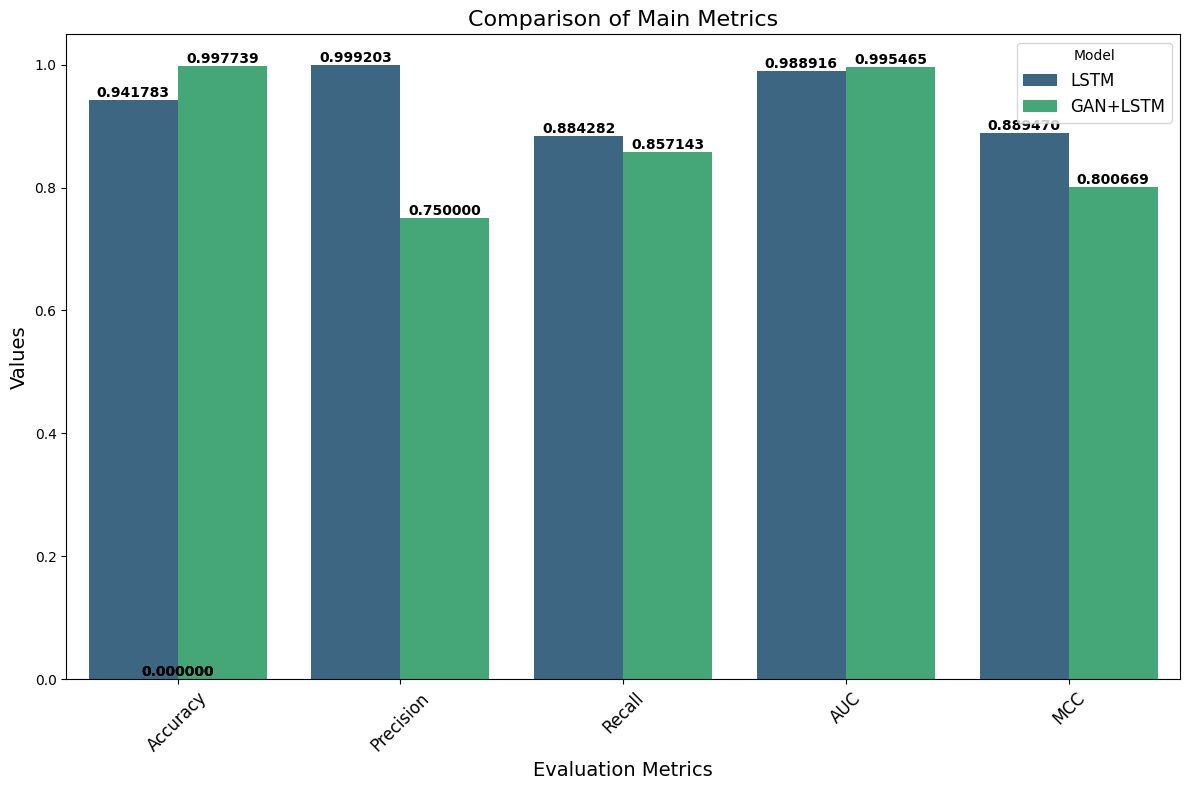

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics for LSTM model
lstm_metrics = {
    "Model": "LSTM",
    "Accuracy": 0.941783,
    "Precision": 0.999203,
    "Recall": 0.884282,
    "AUC": 0.988916,
    "MCC": 0.889470
}

# Metrics for GAN+LSTM model
gan_lstm_metrics = {
    "Model": "GAN+LSTM",
    "Accuracy": 0.997739,
    "Precision": 0.750000,
    "Recall": 0.857143,
    "AUC": 0.995465,
    "MCC": 0.800669
}

# Combine the metrics into a DataFrame
metrics_comparison = pd.DataFrame([lstm_metrics, gan_lstm_metrics])

# Reshape the data for easier plotting
melted_metrics = metrics_comparison.melt(id_vars=["Model"], var_name="Metric", value_name="Value")

# Plot main metrics with value labels
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=melted_metrics, x="Metric", y="Value", hue="Model", palette="viridis")

# Add value labels on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.6f}',  # Format values to 6 decimal places
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Comparison of Main Metrics", fontsize=16)
plt.xlabel("Evaluation Metrics", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Model", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [21]:
import numpy as np
import pandas as pd

# Save y_test and y_pred as CSV files
np.savetxt("y_test_lstm_gan.csv", y_test, delimiter=",")
np.savetxt("y_pred_lstm_gan.csv", y_pred, delimiter=",")


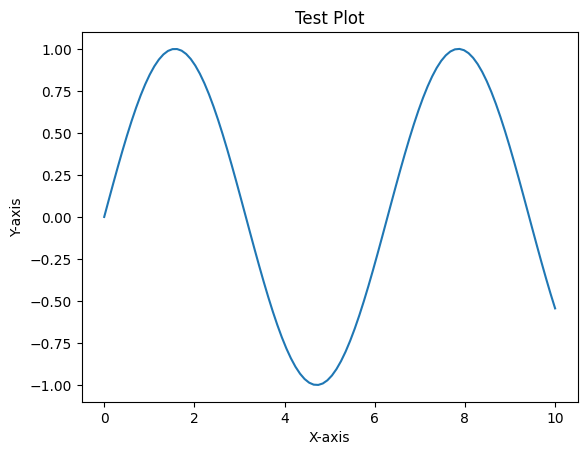

In [31]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10, 100)
y = np.sin(x)

plt.plot(x, y)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Test Plot")
plt.show()


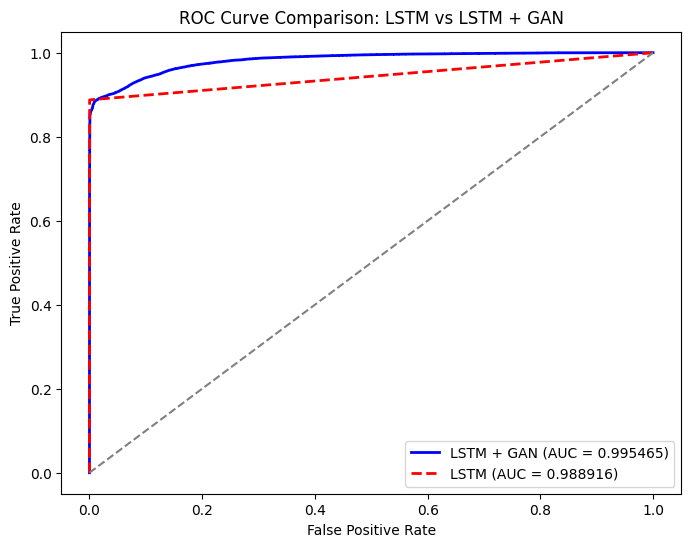

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load predictions and true labels
y_test_lstm = np.loadtxt("y_test_lstm.csv", delimiter=",")
y_pred_lstm = np.loadtxt("y_pred_lstm.csv", delimiter=",")
y_test_lstm_gan = np.loadtxt("y_test_lstm_gan.csv", delimiter=",")
y_pred_lstm_gan = np.loadtxt("y_pred_lstm_gan.csv", delimiter=",")

# Compute ROC curve and AUC for LSTM model
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_lstm, y_pred_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Compute ROC curve and AUC for LSTM + GAN model
fpr_lstm_gan, tpr_lstm_gan, _ = roc_curve(y_test_lstm_gan, y_pred_lstm_gan)
roc_auc_lstm_gan = auc(fpr_lstm_gan, tpr_lstm_gan)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color="blue", lw=2, label=f"LSTM + GAN (AUC = 0.995465)")
plt.plot(fpr_lstm_gan, tpr_lstm_gan, color="red", lw=2, linestyle="--", label=f"LSTM (AUC = 0.988916)")

# Random classifier line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: LSTM vs LSTM + GAN")
plt.legend(loc="lower right")
plt.show()


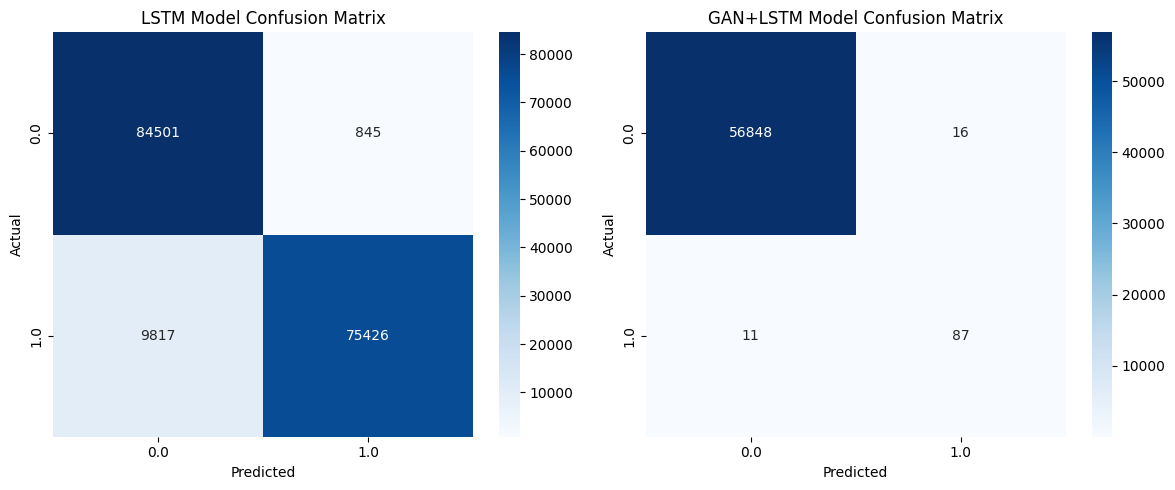

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load data from CSV files
y_test_lstm = np.loadtxt("y_test_lstm.csv", delimiter=",")
y_pred_lstm = np.loadtxt("y_pred_lstm.csv", delimiter=",")
y_test_lstm_gan = np.loadtxt("y_test_lstm_gan.csv", delimiter=",")
y_pred_lstm_gan = np.loadtxt("y_pred_lstm_gan.csv", delimiter=",")

# Convert continuous predictions to class labels
if len(y_pred_lstm.shape) > 1 and y_pred_lstm.shape[1] > 1:  # Multi-class case
    y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
    y_pred_lstm_gan = np.argmax(y_pred_lstm_gan, axis=1)
    y_test_lstm = np.argmax(y_test_lstm, axis=1)
    y_test_lstm_gan = np.argmax(y_test_lstm_gan, axis=1)
else:  # Binary classification
    y_pred_lstm = np.round(y_pred_lstm)
    y_pred_lstm_gan = np.round(y_pred_lstm_gan)
    y_test_lstm = np.round(y_test_lstm)
    y_test_lstm_gan = np.round(y_test_lstm_gan)

# Compute confusion matrices
cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
cm_gan_lstm = confusion_matrix(y_test_lstm_gan, y_pred_lstm_gan)

# Plot side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# LSTM Model Confusion Matrix
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_lstm), yticklabels=np.unique(y_test_lstm), ax=axes[0])
axes[0].set_title("LSTM Model Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# GAN+LSTM Model Confusion Matrix
sns.heatmap(cm_gan_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_lstm_gan), yticklabels=np.unique(y_test_lstm_gan), ax=axes[1])
axes[1].set_title("GAN+LSTM Model Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# Show plot
plt.tight_layout()
plt.show()


In [42]:
from tensorflow.keras.models import load_model

# Load model
lstm_model = load_model("lstm_fraud_detection.h5")

# Test a specific transaction
sample_index = 1
sample_transaction = X_test[sample_index].reshape(1, 1, X_test.shape[2])
sample_label = y_test.iloc[sample_index]

prediction = lstm_model.predict(sample_transaction)

print("Input Transaction:\n", sample_transaction)
print("Actual Label:", sample_label)
print("Predicted Output (Raw):", prediction)
print("Predicted Class:", int(prediction[0][0] > 0.5))  # Threshold at 0.5


2025-04-10 15:09:19.745621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-10 15:09:19.748627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-10 15:09:19.751681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
Input Transaction:
 [[[0.9930263  0.98992699 0.76269124 0.80762648 0.2493928  0.77307101
   0.27716592 0.26458401 0.78912931 0.47419338 0.51003331 0.33761971
   0.74783376 0.45540673 0.66155064 0.33115594 0.42687095 0.73431425
   0.55134946 0.53875444 0.57854055 0.55922827 0.496319   0.66936321
   0.25737155 0.55873386 0.48303516 0.41574951 0.31158208 0.00189559]]]
Actual Label: 0.0
Predicted Output (Raw): [[4.8755064e-05]]
Predicted Class: 0


In [36]:
# Get indices of fraud transactions in the test set
fraud_indices = y_test[y_test == 1].index.tolist()

print(f"Total fraud cases in test set: {len(fraud_indices)}")
print("Fraud case indices:", fraud_indices[:10])  # print first 10 for quick look


Total fraud cases in test set: 98
Fraud case indices: [202284, 124593, 91810, 57695, 22261, 31968, 64026, 192034, 172491, 200386]
